In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from PIL import Image
from datetime import datetime
import math
import copy
import os

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Dataset

In [3]:
class AdjustPixelsRange(object):
    def __init__(self, range_in, range_out):
        self._range_in = torch.tensor(range_in, dtype=torch.float32)
        self._range_out = torch.tensor(range_out, dtype=torch.float32)

        if range_in == range_out:
            self.scale = 1
            self.bias = 0
        else:
            self.scale = (self._range_out[1] - self._range_out[0]) / (self._range_in[1] - self._range_in[0])
            self.bias = self._range_out[0] - self.scale * self._range_in[0]
    
    def __call__(self, x):
        return torch.clamp(self.scale * x + self.bias, min=self._range_out[0], max=self._range_out[1])

In [5]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])
dataset = torchvision.datasets.MNIST('../data/mnist', train=True, transform=transform, download=False)

dataset[0][0].min(), dataset[0][0].max()

(tensor(-1.), tensor(0.9843))

## DDPM

$q(x_t|x_{t-1}) = \mathscr{N}(\sqrt{1-\beta_t}x_{t-1}, \beta_t I)$

$\textcolor{#FF9800}{q(x_t|x_0)} = \mathscr{N}(\sqrt{\bar{\alpha}_t}x_0, (1-\bar{\alpha}_t) I)$
$\textcolor{#FFFF00}{\;\;\;\longrightarrow\;\;\; x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1-\bar{\alpha}_t}\epsilon}$
$\textcolor{#76FF03}{\;\;\;\longrightarrow\;\;\; x_0 = x_t \Large \frac{1}{\sqrt{\bar{\alpha}_t}} \normalsize - \epsilon\sqrt{\Large \frac{1}{\bar{\alpha}_t} \normalsize-1}}$

<hr width=400 align="left">

$\textcolor{#FF3D00}{q(x_{t-1}|x_{t}, x_0)} = \mathscr{N}(\textcolor{cyan}{\tilde{\mu}_t(x_t, x_0)}, \textcolor{#EA80FC}{\tilde{\beta}_t I})$

$\Large \textcolor{cyan}{\tilde{\mu}_t(x_t, x_0) = \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t}x_0 + \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t}x_t}$
$\Large \;\;\;\textcolor{cyan}{\longrightarrow\;\;\; \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}}\epsilon_t)} \;\;\;\;$
(note that $\textcolor{cyan}{\epsilon_t}$ was used to generate $x_t$ using $\textcolor{#FF9800}{q(x_t|x_0)}$)

$\Large \textcolor{#EA80FC}{\tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \beta_t}$

In [6]:
class DDPM:
    def __init__(self, T=1000, beta_1=1e-4, beta_T=2e-2, device='cpu', posterior_var_type='fixedlarge'):
        self.T = T
        
        self.betas = torch.linspace(beta_1, beta_T, steps=T, dtype=torch.double).to(device)
        self.alphas = 1. - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.prev_alpha_bars = torch.cat([torch.ones(1, device=device), self.alpha_bars[:-1]], dim=0).clone().to(device)

        # Calculation of q(x_t | x_0)  ->  [Yellow Equation]
        self.sqrt_alpha_bars = torch.sqrt(self.alpha_bars).float()
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1 - self.alpha_bars).float()

        # Calculation of x_0 from x_t and epsilon  ->  [Green Equation]
        self.sqrt_recip_alpha_bars = torch.sqrt(1. / self.alpha_bars).float()
        self.sqrt_recip_alpha_bars_minus_one = torch.sqrt(1. / self.alpha_bars - 1).float()

        # Calculation of q(x_{t-1} | x_t , x_0)  ->  [Red Equation]
        self.posterior_mean_coef_x0 = (self.betas * torch.sqrt(self.prev_alpha_bars) / (1 - self.alpha_bars)).float()
        self.posterior_mean_coef_xt = (torch.sqrt(self.alphas) * (1 - self.prev_alpha_bars) / (1 - self.alpha_bars)).float()
        if posterior_var_type == 'fixedlarge':
            self.posterior_log_variance = torch.log(self.betas).float()
        elif posterior_var_type == 'fixedsmall':
            posterior_variance = (((1 - self.prev_alpha_bars) / (1 - self.alpha_bars)) * self.betas).float()
            self.posterior_log_variance = torch.log(torch.maximum(posterior_variance, torch.tensor(1e-20))).float() # This was done in the original TF repo.
        else:
            raise Exception("Unknown posterior_var_type argument")


    # Calculation of q(x_t | x_0)  ->  [Yellow Equation]
    def calculate_xt_from_x0(self, x_0, t, eps=None):
        t = self._fix_t_view(t)

        if eps is None:
            eps = torch.randn_like(x_0)

        x_t = self.sqrt_alpha_bars[t] * x_0 + self.sqrt_one_minus_alpha_bars[t] * eps

        return x_t, eps

    # Calculation of x_0 from x_t and epsilon  ->  [Green Equation]
    def calculate_x0_from_xt_and_eps(self, x_t, t, eps):
        t = self._fix_t_view(t)

        x_0 = self.sqrt_recip_alpha_bars[t] * x_t - self.sqrt_recip_alpha_bars_minus_one[t] * eps

        return x_0
    
    # Calculation of q(x_{t-1} | x_t , x_0)  ->  [Red Equation]
    def calculate_xprev_from_xt_and_x0(self, x_t, t, x_0):
        t = self._fix_t_view(t)
        
        mean = self.posterior_mean_coef_x0[t] * x_0 + self.posterior_mean_coef_xt[t] * x_t
        std = torch.exp(0.5 * self.posterior_log_variance[t])
        std[t == 0] = 0

        xprev = mean + std * torch.randn_like(x_t)

        return xprev
    
    def _fix_t_view(self, t):
        assert t.ndim == 1 and torch.all(t >= 0) and torch.all(t < self.T)
        return t[:, None, None, None]
    
    def reverse_process_from_xt_using_model(self, model: nn.Module, x_t, t_end: int):
        out = x_t

        for t in range(t_end, -1, -1):
            t_tensor = torch.full((x_t.shape[0], ), t).to(x_t.device)
            eps = model(out, t_tensor)
            x_0_pred = self.calculate_x0_from_xt_and_eps(out, t_tensor, eps)
            out = self.calculate_xprev_from_xt_and_x0(out, t_tensor, x_0_pred).detach()

        return out

In [7]:
ddpm = DDPM()

### Visualizing $\textcolor{#888}{q(x_t|x_0)}$ and $\textcolor{#888}{x_0 = x_t \frac{1}{\sqrt{\bar{\alpha}_t}} - \epsilon\sqrt{\frac{1}{\bar{\alpha}_t}-1}}$

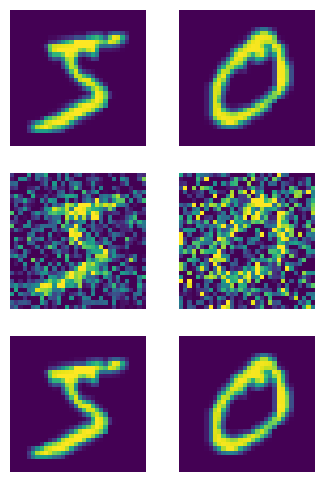

In [8]:
t = torch.tensor([200, 300])
inputs = torch.stack((dataset[0][0], dataset[1][0]), dim=0).double()

res, epsilon = ddpm.calculate_xt_from_x0(inputs, t)

fig, axs = plt.subplots(3, 2, figsize=(4, 6))
for i in range(2):
    axs[0][i].axis('off')
    axs[0][i].imshow(AdjustPixelsRange((-1, 1), (0, 1))(inputs[i].permute(1, 2, 0)))
    
for i in range(2):
    axs[1][i].axis('off')
    axs[1][i].imshow(AdjustPixelsRange((-1, 1), (0, 1))(res[i].permute(1, 2, 0)))

res2 = ddpm.calculate_x0_from_xt_and_eps(res, t, epsilon)

for i in range(2):
    axs[2][i].axis('off')
    axs[2][i].imshow(AdjustPixelsRange((-1, 1), (0, 1))(res2[i].permute(1, 2, 0)))

### Visualizing $\textcolor{#888}{q(x_t|x_0)}$ over time ($t$)

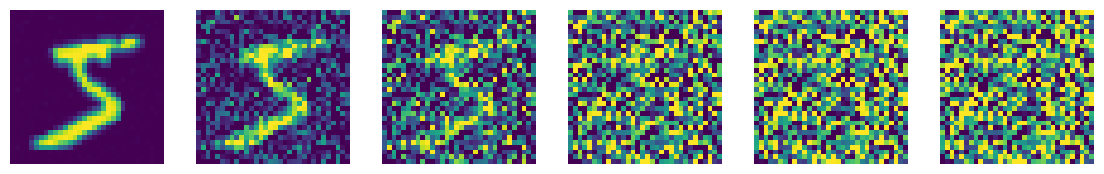

In [9]:
t = torch.tensor([0, 150, 300, 500, 750, 999])
res, epsilon = ddpm.calculate_xt_from_x0(dataset[0][0], t)

fig, axs = plt.subplots(1, t.shape[0], figsize=(14, 2))
for i in range(t.shape[0]):
    axs[i].axis('off')
    axs[i].imshow(AdjustPixelsRange((-1, 1), (0, 1))(res[i].permute(1, 2, 0)))

### Visualizing $\textcolor{#888}{q(x_{t-1}|x_{t}, x_0)}$

calculate_xprev_from_xt_and_x0 == x_0_pred: True


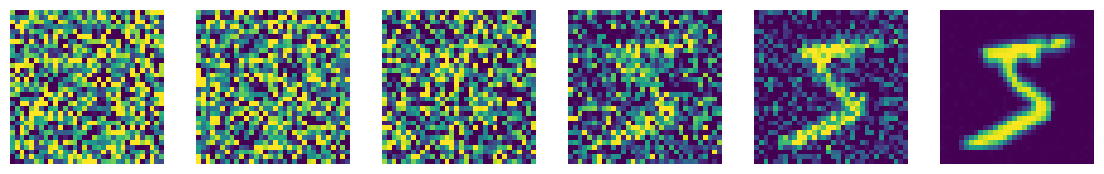

In [10]:
t = torch.tensor([999])
x_t = res[-1].clone()

t_arr = [750, 500, 300, 150, 0]
res2 = [x_t.unsqueeze(0)]

x_0_pred = ddpm.calculate_x0_from_xt_and_eps(x_t, t, epsilon)

while t >= 0:
    x_t = ddpm.calculate_xprev_from_xt_and_x0(x_t, t, x_0_pred)
    t = t - 1
    if t in t_arr:
        res2.append(x_t)

print("calculate_xprev_from_xt_and_x0 == x_0_pred:", torch.allclose(x_t, x_0_pred))

fig, axs = plt.subplots(1, len(res2), figsize=(14, 2))
for i in range(len(res2)):
    axs[i].axis('off')
    axs[i].imshow(AdjustPixelsRange((-1, 1), (0, 1))(res2[i][0].permute(1, 2, 0)))

### Why?

$\large \textcolor{#666}{q(x_{t-1}|x_{t}, x_0) = \mathscr{N}(\textcolor{#aaa}{\tilde{\mu}_t(x_t, x_0)}, \tilde{\beta}_t I)}$

$\Large \textcolor{#aaa}{\tilde{\mu}_t(x_t, x_0) = \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t}x_0 + \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t}x_t}$

Lets visualize the coefficients of $x_0$ and $x_t$ 

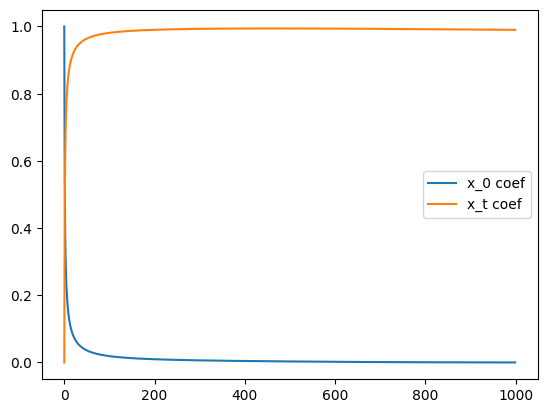

In [11]:
plt.plot(ddpm.posterior_mean_coef_x0, label='x_0 coef')
plt.plot(ddpm.posterior_mean_coef_xt, label='x_t coef')
plt.legend();

## U-Net Architecture


In the preceding portion, we examined the UNet architecture. In this section, we'll make adjustments to enhance the model's performance and implement essential modifications to accommodate new inputs, specifically text embedding.

### Time Embedding

$PE(pos, 2i) \;\;\;\;\;\; = sin(\frac{pos}{10000^{\frac{2i}{d_{model}}}})$

$PE(pos, 2i+1) = cos(\frac{pos}{10000^{\frac{2i}{d_{model}}}})$

torch.Size([32, 100])


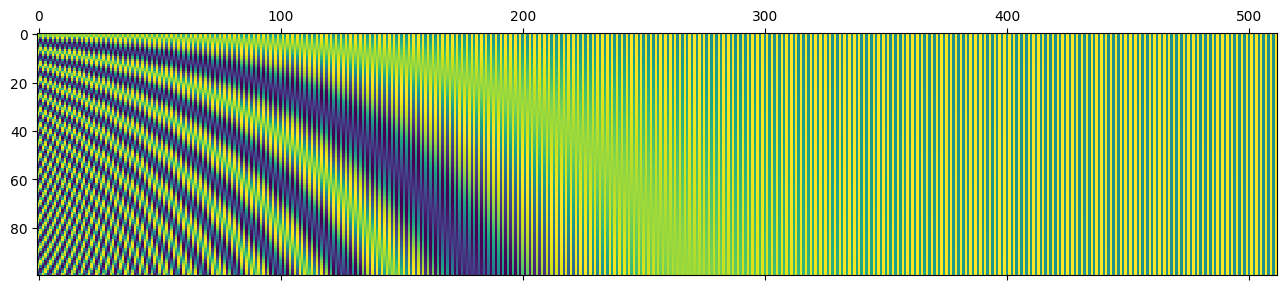

In [12]:
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, max_pos, d_model, out_dim):
        super().__init__()

        assert d_model % 2 == 0

        numerator = torch.arange(0, max_pos, dtype=torch.float)
        denominator = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        frac = numerator.unsqueeze(1) @ denominator.unsqueeze(0) # (pos_max, d_model//2)

        self.embd = torch.stack((torch.sin(frac), torch.cos(frac)), dim=-1).view(max_pos, d_model)

        self.net = nn.Sequential(
            nn.Embedding.from_pretrained(self.embd),
            nn.Linear(d_model, out_dim),
            nn.SiLU(),
            nn.Linear(out_dim, out_dim),
        )

    def forward(self, t):
        return self.net(t)


emb = SinusoidalTimeEmbedding(max_pos=100, d_model=512, out_dim=100)
print(emb(torch.randint(low=0, high=100, size=(32, ))).shape)
plt.matshow(emb.embd);

### Attention Block

$softmax(\frac{QK^T}{\sqrt{d_k}})V$

In [13]:
class AttentionBlock(nn.Module):
    def __init__(self, in_channels, gp_norm_groups=16):
        super().__init__()

        self.gp_norm = nn.GroupNorm(num_groups=gp_norm_groups, num_channels=in_channels, eps=1e-6)

        self.proj_q = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.proj_k = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.proj_v = nn.Conv2d(in_channels, in_channels, kernel_size=1)

        self.proj_out = nn.Conv2d(in_channels, in_channels, kernel_size=1)
    
    def forward(self, x):
        B, C, H, W = x.shape

        h = self.gp_norm(x)

        q = self.proj_q(h)
        k = self.proj_k(h)
        v = self.proj_v(h)

        alpha = q.permute(0, 2, 3, 1).view(B, H*W, C) @ k.view(B, C, H*W)
        alpha = alpha / np.sqrt(C)
        alpha = torch.softmax(alpha, dim=-1)

        out = v.view(B, C, H*W) @ alpha.permute(0, 2, 1)
        out = out.view(B, C, H, W)
        # out = alpha @ v.permute(0, 2, 3, 1).view(B, H*W, C)
        # out = out.view(B, H, W, C).permute(0, 3, 1, 2)
        out = self.proj_out(out)

        return out + x


AttentionBlock(64)(torch.randn(8, 64, 10, 10)).shape

torch.Size([8, 64, 10, 10])

### Up/Down Sampling

In [14]:
class DownSample(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.net = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=2, padding=0)

    def forward(self, x):
        x = torch.nn.functional.pad(x, (0, 1, 0, 1), mode="constant", value=0)
        return self.net(x)


DownSample(in_channels=3)(torch.randn(32, 3, 28, 28)).shape

torch.Size([32, 3, 14, 14])

In [15]:
class UpSample(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.net = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        )
    
    def forward(self, x):
        return self.net(x)


UpSample(in_channels=3)(torch.randn(32, 3, 14, 14)).shape

torch.Size([32, 3, 28, 28])

### Resnet Block

In [16]:
class ResnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_embd_channels, dropout_prob, use_attention=False, gp_norm_groups=16):
        super().__init__()

        self.net1 = nn.Sequential(
            nn.GroupNorm(num_groups=gp_norm_groups, num_channels=in_channels, eps=1e-6),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )

        self.proj_t = nn.Sequential(
            nn.SiLU(),
            nn.Linear(t_embd_channels, out_channels)
        )

        self.net2 = nn.Sequential(
            nn.GroupNorm(num_groups=gp_norm_groups, num_channels=out_channels, eps=1e-6),
            nn.SiLU(),
            nn.Dropout(p=dropout_prob),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )

        self.shortcut_fn = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, kernel_size=1)

        self.attention = None if not use_attention else AttentionBlock(out_channels, gp_norm_groups=gp_norm_groups)

    def forward(self, x, t_embd):
        out = self.net1(x)
        out = out + self.proj_t(t_embd)[:, :, None, None]
        out = self.net2(out)
        out = out + self.shortcut_fn(x)
        if self.attention is not None:
            out = self.attention(out)

        return out


ResnetBlock(in_channels=32, out_channels=64, t_embd_channels=10, dropout_prob=0.1, use_attention=True)(
    x=torch.randn(8, 32, 20, 20),
    t_embd=torch.randn(8, 10)
).shape

torch.Size([8, 64, 20, 20])

### Putting all together (U-Net)

In [17]:
class UNet(nn.Module):
    def __init__(self, 
            img_channels,
            start_channels,
            channels_multiplier_arr: list,
            levels_to_apply_attention: list,
            dropout_prob=0.1,
            num_resnet_blocks=2,
            max_time=1000,
            gp_norm_groups=16
        ):
        super().__init__()

        assert len(channels_multiplier_arr) == len(levels_to_apply_attention)

        time_embedding_dim = start_channels * 4

        self.time_embedding = SinusoidalTimeEmbedding(max_pos=max_time, d_model=start_channels, out_dim=time_embedding_dim)

        self.from_rgb_conv = nn.Conv2d(img_channels, start_channels, kernel_size=3, padding=1)
        
        ################ Building Down Blocks ################
        self.down_blocks = nn.ModuleList()
        curr_in_channels = start_channels
        skips_channels = [curr_in_channels]
        for level, ch_multiplier in enumerate(channels_multiplier_arr):
            out_channels = start_channels * ch_multiplier
            for _ in range(num_resnet_blocks):
                self.down_blocks.append(
                    ResnetBlock(
                        curr_in_channels,
                        out_channels,
                        time_embedding_dim,
                        dropout_prob,
                        use_attention=levels_to_apply_attention[level], 
                        gp_norm_groups=gp_norm_groups
                    )
                )
                curr_in_channels = out_channels
                skips_channels.append(curr_in_channels)
            if level != len(channels_multiplier_arr)-1:
                self.down_blocks.append(DownSample(curr_in_channels))
                skips_channels.append(curr_in_channels)
        
        ################ Building Middle Blocks ################
        self.middle_blocks = nn.ModuleList([
            ResnetBlock(curr_in_channels, curr_in_channels, time_embedding_dim, dropout_prob, use_attention=True, gp_norm_groups=gp_norm_groups),
            ResnetBlock(curr_in_channels, curr_in_channels, time_embedding_dim, dropout_prob, use_attention=False, gp_norm_groups=gp_norm_groups),
        ])

        ################ Building Up Blocks ################
        self.up_blocks = nn.ModuleList()
        for level in reversed(range(len(channels_multiplier_arr))):
            ch_multiplier = channels_multiplier_arr[level]
            out_channels = start_channels * ch_multiplier
            for _ in range(num_resnet_blocks + 1):
                self.up_blocks.append(
                    ResnetBlock(
                        curr_in_channels + skips_channels.pop(),
                        out_channels,
                        time_embedding_dim,
                        dropout_prob,
                        use_attention=levels_to_apply_attention[level],
                        gp_norm_groups=gp_norm_groups
                    )
                )
                curr_in_channels = out_channels
            if level != 0:
                self.up_blocks.append(UpSample(curr_in_channels))
        
        assert len(skips_channels) == 0

        self.to_noise = nn.Sequential(
            nn.GroupNorm(num_groups=gp_norm_groups, num_channels=curr_in_channels, eps=1e-6),
            nn.SiLU(),
            nn.Conv2d(curr_in_channels, img_channels, kernel_size=3, padding=1)
        )

    def forward(self, x, t):
        t_embd = self.time_embedding(t)

        ######## Down Blocks ########
        out = self.from_rgb_conv(x)
        skips = [out]
        for block in self.down_blocks:
            if isinstance(block, ResnetBlock):
                out = block(out, t_embd)
            elif isinstance(block, DownSample):
                out = block(out)
            else:
                raise Exception("Unexpected block in Down Blocks")
            skips.append(out)
        
        ######## Middle Blocks ########
        for block in self.middle_blocks:
            out = block(out, t_embd)
        
        ######## Up Blocks ########
        for block in self.up_blocks:
            if isinstance(block, ResnetBlock):
                out = block(torch.cat((skips.pop(), out), dim=1), t_embd)
            elif isinstance(block, UpSample):
                out = block(out)
            else:
                raise Exception("Unexpected block in Up Blocks")
        assert len(skips) == 0
        
        out = self.to_noise(out)

        return out


UNet(
    img_channels=3,
    start_channels=32,
    channels_multiplier_arr=[2, 3, 4, 5],
    levels_to_apply_attention=[False, True, False, False],
    dropout_prob=0.1,
    num_resnet_blocks=2,
    max_time=1000
)(torch.randn(20, 3, 32, 32), torch.randint(0, ddpm.T, (20, ))).shape

torch.Size([20, 3, 32, 32])

## Training

In [18]:
def update_exponential_moving_average_model(ema_model, model, decay=0.9999):
    model_named_parameters = dict(model.named_parameters())
    with torch.no_grad():
        for param_name, param in ema_model.named_parameters():
            param.copy_(param * decay + (1. - decay) * model_named_parameters[param_name])

In [19]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

ddpm = DDPM(device=device)

model = UNet(
    img_channels=1,
    start_channels=64,
    channels_multiplier_arr=[1, 1, 2, 2],
    levels_to_apply_attention=[False, True, False, False],
    dropout_prob=0.1,
    num_resnet_blocks=2,
    max_time=ddpm.T
).to(device)

ema_model = copy.deepcopy(model)
update_exponential_moving_average_model(ema_model, model, decay=0)


opt = torch.optim.Adam(model.parameters(), lr=2e-4)

scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.5)

In [20]:
print("Numer of parameters:", sum(p.numel() for p in model.parameters()))

Numer of parameters: 6948609


In [21]:
train_loss_arr = []

model.train()
for epoch in range(50):
    train_loss = 0.
    for idx, (images, _) in enumerate(dataloader):
        images = images.to(device)

        t = torch.randint(0, ddpm.T, (images.shape[0]//2 + 1, )).to(device)
        t = torch.cat([t, ddpm.T - t - 1], dim=0)[:images.shape[0]]

        noisy_images, noise = ddpm.calculate_xt_from_x0(x_0=images, t=t)

        predicted_noise = model(noisy_images, t)

        # loss = F.mse_loss(predicted_noise, noise, reduction='none').mean()
        loss = (noise - predicted_noise).square().sum(dim=(1, 2, 3)).mean(dim=0)

        opt.zero_grad()
        loss.backward()
        try:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        except Exception:
            pass
        opt.step()

        train_loss += loss.item() * images.shape[0]

        update_exponential_moving_average_model(ema_model, model)

    scheduler.step()

    train_loss /= len(dataloader.dataset)
    train_loss_arr.append(train_loss)
    
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] [Epoch {epoch:2d}] Train Loss: {train_loss:.8f}")

[2023-12-12 09:13:37] [Epoch  0] Train Loss: 44.49903129
[2023-12-12 09:15:55] [Epoch  1] Train Loss: 23.63425404
[2023-12-12 09:18:20] [Epoch  2] Train Loss: 21.15789421
[2023-12-12 09:20:46] [Epoch  3] Train Loss: 19.83028097
[2023-12-12 09:23:14] [Epoch  4] Train Loss: 18.90683050
[2023-12-12 09:25:42] [Epoch  5] Train Loss: 18.63717816
[2023-12-12 09:28:08] [Epoch  6] Train Loss: 17.98478199
[2023-12-12 09:30:34] [Epoch  7] Train Loss: 17.91394328
[2023-12-12 09:32:59] [Epoch  8] Train Loss: 17.55474797
[2023-12-12 09:35:26] [Epoch  9] Train Loss: 17.41653680
[2023-12-12 09:37:52] [Epoch 10] Train Loss: 17.21864571
[2023-12-12 09:40:18] [Epoch 11] Train Loss: 17.20153039
[2023-12-12 09:42:48] [Epoch 12] Train Loss: 16.97032271
[2023-12-12 09:45:18] [Epoch 13] Train Loss: 16.91118282
[2023-12-12 09:47:46] [Epoch 14] Train Loss: 16.69590885
[2023-12-12 09:50:10] [Epoch 15] Train Loss: 16.33278538
[2023-12-12 09:52:35] [Epoch 16] Train Loss: 16.46962675
[2023-12-12 09:55:02] [Epoch 17

In [26]:
# torch.save(model.state_dict(), 'mnist_results/model.pth')
# torch.save(train_loss_arr, 'mnist_results/train_loss_arr.pth')

model.load_state_dict(torch.load("mnist_results/model.pth"))
# ema_model.load_state_dict(torch.load("mnist_results/ema_model.pth"))
train_loss_arr = torch.load("mnist_results/train_loss_arr.pth")

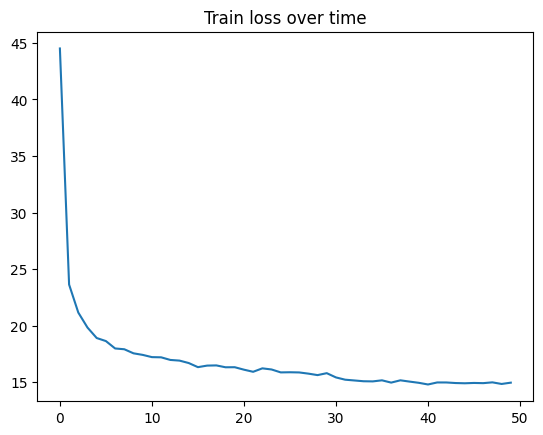

In [22]:
plt.plot(train_loss_arr)
plt.title("Train loss over time");

## Evaluation

In [23]:
model.eval()
ema_model.eval();

### Generation

In [24]:
generated_images_batch = ddpm.reverse_process_from_xt_using_model(
    model=model,
    x_t=torch.randn(64, 1, 32, 32).to(device),
    t_end=ddpm.T-1
)

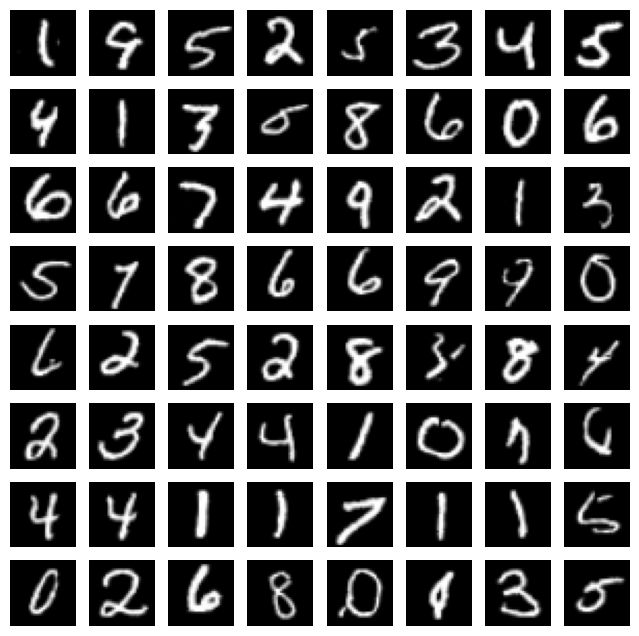

In [25]:
fig, axs = plt.subplots(8, 8, figsize=(8, 8))
for i in range(64):
    axs[i//8][i%8].axis('off')
    axs[i//8][i%8].imshow(AdjustPixelsRange((-1, 1), (0, 1))(generated_images_batch[i].detach().cpu().permute(1, 2, 0)), cmap='gray')

### Reverse Process from different $t$ s

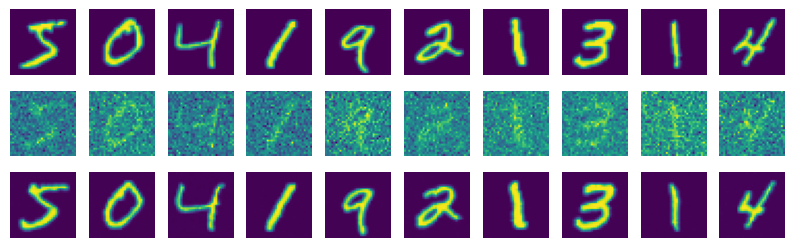

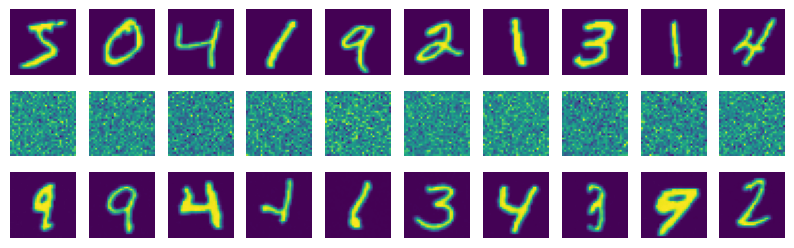

In [27]:
for t_diffuse in [300, ddpm.T-1]:
    images = torch.stack([dataset[i][0] for i in range(10)], dim=0).to(device)
    t = torch.full((images.shape[0], ), t_diffuse, dtype=torch.long, device=device)

    noisy_images, _ = ddpm.calculate_xt_from_x0(images, t=t)

    generated_images = ddpm.reverse_process_from_xt_using_model(model=model, x_t=noisy_images, t_end=t_diffuse)

    fig, axs = plt.subplots(3, 10, figsize=(10, 3))
    for i in range(images.shape[0]):
        for j in range(3):
            axs[j][i].axis('off')
        axs[0][i].imshow(images[i].cpu().permute(1, 2, 0))
        axs[1][i].imshow(noisy_images[i].cpu().permute(1, 2, 0))
        axs[2][i].imshow(generated_images[i].cpu().permute(1, 2, 0))
    plt.show()

### Interpolation

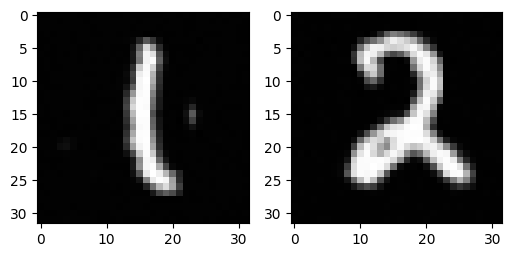

In [28]:
selected_images = generated_images_batch[[0, 3]]

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(selected_images[0].detach().cpu().permute(1, 2, 0), cmap='gray')
axs[1].imshow(selected_images[1].detach().cpu().permute(1, 2, 0), cmap='gray');

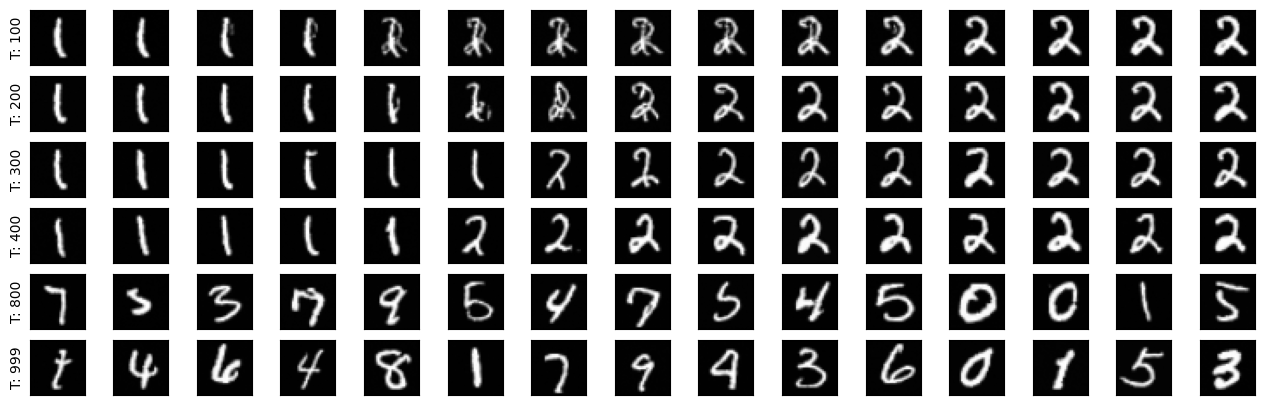

In [29]:
T_interpolation_arr = [100, 200, 300, 400, 800, 999]

cnt = 15
percentage = torch.linspace(0, 1, cnt).view(cnt, 1, 1, 1).to(noisy_images[0].device)

fig, axs = plt.subplots(len(T_interpolation_arr), cnt, figsize=(16, 5))

for i, T_interpolation in enumerate(T_interpolation_arr):
    noisy_images, _ = ddpm.calculate_xt_from_x0(selected_images, t=torch.tensor([T_interpolation, T_interpolation]))
    intermediate_noisy_images = noisy_images[0] * (1 - percentage) + noisy_images[1] * percentage
    generated_from_interpolation = ddpm.reverse_process_from_xt_using_model(model=model, x_t=intermediate_noisy_images, t_end=T_interpolation)

    axs[i][0].set_ylabel(f"T: {T_interpolation}")
    for j in range(cnt):
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].imshow(generated_from_interpolation[j].detach().cpu().permute(1, 2, 0), cmap='gray')